# Rolling Resample

#### 1. Check rates in overall session, and then accounting for rearing and not-rearing *Remember to convert to binary, i.e., spike or no spike.* 

#### 2. Check small-worldness of networks during anxiety tasks, in each experiment. 

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from IPython.core.interactiveshell import InteractiveShell

# from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
# from oasis.plotting import simpleaxis
# from oasis.oasis_methods import oasisAR1, oasisAR2

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


In [4]:
drd87_raw_data = pd.read_csv(raw_files[7], header=None)
deconvoluter = Deconvoluter(drd87_raw_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

# Reindex neuron column vectors from 0, 1, 2, ..., n --> 1, 2, 3, ..., n, n+1
deconvoluter.cell_transients.columns = [col+1 for col in deconvoluter.cell_transients.columns]
deconvoluter.cell_auc_df.columns = [col+1 for col in deconvoluter.cell_auc_df.columns]

behavior_df = pd.read_csv(raw_files[8], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [5]:
drd87_fe.auc_df = drd87_fe.auc_df.where(drd87_fe.auc_df == 0, 1)

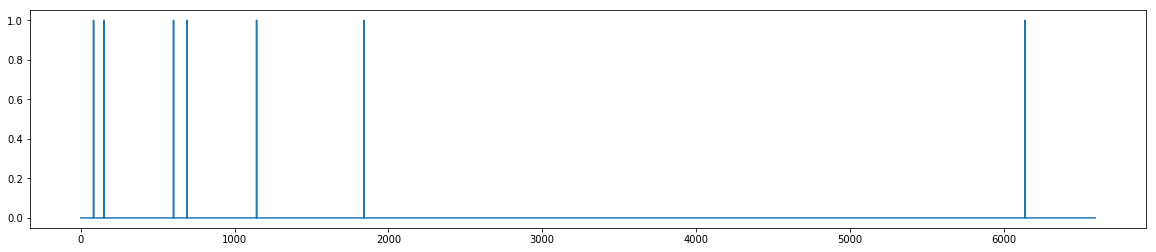

In [6]:
plt.figure(figsize=(20, 4))
plt.plot(drd87_fe.auc_df.loc[:, 4].values);

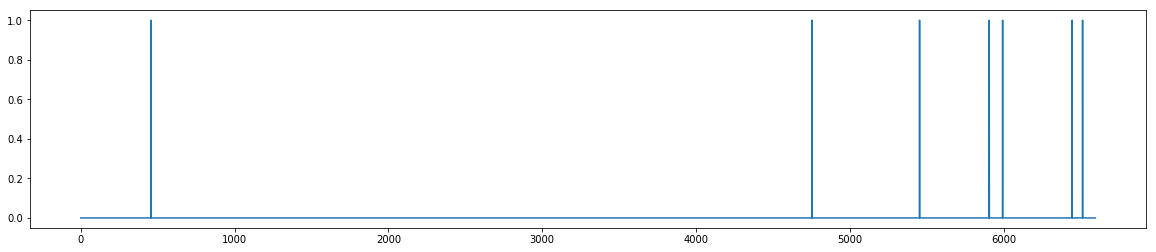

In [7]:
plt.figure(figsize=(20, 4))
plt.plot(np.flip(drd87_fe.auc_df.loc[:, 4].values, axis=0));

In [8]:
def roll_worker(queue, dataframe, neuron_x, neuron_y, resamples):
    """Helper function for roll()
    
        Note: This function is only meant to be called by roll(), i.e.,
        this function should not used as a standalone function.
        
        Args: 
            queue: Queue
            
                The blocking Queue to add the list of computed correlation 
                coefficients that this function produces.
                
            dataframe: DataFrame
            
                A T x N matrix, where T := # of rows (observations) and 
                N := # of neuron column vectors. 
                
            neuron_x: 
            
                The name of a neuron column vector in the provided dataframe.
            
            neuron_y:
            
                The name of a neuron column vector in the provided dataframe.
            
            resamples: int
            
                The amount of times to compute the test statistic, i.e., 
                correlation coefficient between the two provided neurons.
        
        Returns:
            corr_coefficients: list
            
                A list of all the computed correlation coefficients between
                the two provided neurons.
    """
    corr_coefficients = []
    high = len(dataframe.loc[:, neuron_x].index)
    
    time_series_x = dataframe.loc[:, neuron_x].values
    time_series_y = dataframe.loc[:, neuron_y].values
    for _ in range(resamples):
        time_series_x = np.roll(time_series_x, shift=np.random.randint(1, high))
        time_series_y = np.roll(time_series_y, shift=np.random.randint(1, high))
        corr_coefficients.append(np.corrcoef(time_series_x, time_series_y)[0][1])
    
    queue.put(corr_coefficients)

In [9]:
from multiprocessing import Process
from multiprocessing import Queue

def roll(dataframe, neuron_x, neuron_y, resamples):
    """Create resampled distribution of correlation coefficients for two neurons
    
        Args:
            dataframe: DataFrame
            
                A T x N matrix, where T := # of rows (observations) and 
                N := # of neuron column vectors. 
            
            neuron_x: 

                The name of a neuron column vector in the provided dataframe.

            neuron_y:

                The name of a neuron column vector in the provided dataframe.

            resamples: int

                The amount of times to compute the test statistic, i.e., 
                correlation coefficient between the two provided neurons.

        Returns:
            corr_coefficients: list

                A list of all the computed correlation coefficients between
                the two provided neurons.
    """
    resamples_per_worker = resamples // os.cpu_count()
    queue = Queue()
    processes = []
    rets = []
    
    for _ in range(os.cpu_count()):
        process = Process(target=roll_worker, args=(queue, dataframe, neuron_x, neuron_y, resamples_per_worker))
        processes.append(process)
        process.start()
    for process in processes:
        ret = queue.get()  # will block
        rets.append(ret)
    for process in processes:
        process.join()

    corr_coefficients = [item for sublist in rets for item in sublist]
        
    return corr_coefficients

In [10]:
%timeit roll(drd87_fe.auc_df, 35, 67, 10000)

958 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def one_sided_p_val(actual_corrcoef, corr_coefficients):
    """Compute the one sided p-value of correlation coefficients.
    
        Args:
            actual_corrcoef: float
            
                The actual correlation coefficient of a pair of
                neurons.
                
            corr_coefficients: list
                
                The resampled distribution of all the possible correlation
                coefficients between two neurons.
            
        Returns:
            p_value: float
            
                The computed one sided p-value.
    """
    p = len(corr_coefficients)
    D = actual_corrcoef
    
    count = 0
    for D_i in corr_coefficients:
        if D_i >= D:
            count += 1
            
    p_value = (1 / p) * count
    
    return p_value

In [12]:
def get_corr_pairs(dataframe, **kwargs):
    """Find pairs of correlated neurons
    
        Goes through all possible pairs of neurons and 
        saves the pairs that have statistically significant
        correlation coefficients. 
        
        Args: 
            dataframe: DataFrame
                
                A T x N matrix, where T := # of rows (observations) and 
                N := # of neuron column vectors of all of the neurons.
                
            p_val: float, optional
            
                The p_val to use as the threshold for when to reject the null
                hypothesis, i.e., that the correlation coefficient of the pair 
                of neurons are is statistically significant; default is 0.05
            
            resamples: int, optional
            
                The amount of times to roll the two neural time series, i.e.,
                the neural time series data from a given pair of neurons; 
                default is 10000.
                
        Returns:
            
            corr_pairs: dictionary
            
                A dictionary that contains all of the statistically significant 
                correlated pairs and their respective correlation coefficient, 
                as such: <(neuron_x, neuron_y), corrcoef>
    """
    corr_pairs = {}
    p_val = kwargs.get("p_val", 0.05)
    resamples = kwargs.get("resamples", 10000)

    for i in range(1, len(dataframe.columns)+1):
        for j in range(i+1, len(dataframe.columns)+1):

            # Compute the real corrcoef between spiking data of two neurons
            actual_corrcoef = np.corrcoef(dataframe.loc[:, i], dataframe.loc[:, j])[0][1]

            # Skip this iteration if the real corrcoef is not positive
            if actual_corrcoef <= 0:
                continue

            # Carry out the rolling to build a resampled distribution
            resampled_vals = roll(dataframe, i, j, resamples)

            if one_sided_p_val(actual_corrcoef, resampled_vals) < p_val:
                corr_pairs[(i, j)] = actual_corrcoef
                
    return corr_pairs

In [13]:
%time corr_pairs = get_corr_pairs(drd87_fe.auc_df, p_val=0.01)

CPU times: user 16.8 s, sys: 7.16 s, total: 24 s
Wall time: 6min 29s


In [14]:
corr_pairs

{(1, 17): 0.10021840800737927,
 (1, 35): 0.11042265907782188,
 (1, 61): 0.17115511136726877,
 (2, 13): 0.21961675111512455,
 (2, 29): 0.28959290509883706,
 (2, 51): 0.08589554866804755,
 (2, 53): 0.12298420218389766,
 (2, 62): 0.1648285207424397,
 (3, 12): 0.11314504382313788,
 (3, 26): 0.049972863839501704,
 (3, 59): 0.057373158626308686,
 (4, 16): 0.08513087744895709,
 (4, 20): 0.0930493488230803,
 (4, 46): 0.17201309390807837,
 (6, 16): 0.26102991176070645,
 (6, 22): 0.04272240525138583,
 (6, 42): 0.09280002584461271,
 (6, 43): 0.05141511328239088,
 (7, 26): 0.05649906094309642,
 (8, 14): 0.09942372158413443,
 (8, 49): 0.23175235515018383,
 (9, 36): 0.11278448221694824,
 (9, 46): 0.17201309390807795,
 (10, 14): 0.07021768672287258,
 (10, 21): 0.0602210574293528,
 (10, 56): 0.13499952700704884,
 (11, 35): 0.12218461355863072,
 (11, 37): 0.13279860654905937,
 (11, 50): 0.2495829167830806,
 (11, 63): 0.10554705268218106,
 (12, 26): 0.05851399012232643,
 (13, 29): 0.2471488384480915,
 (